In [2]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import scale.olm.contrib as contrib
import scale.olm.core as core
from pathlib import Path
import scale.olm.complib as complib
import numpy as np
import matplotlib.pyplot as plt
import json

In [42]:
scale_path = '/home/hts/codes/scale/build/INSTALL'

In [3]:
file = Path('data/Beznau-1_M308_K7_BM5_sample_burnup.txt')
with open(file,'r') as input:
    time,burnup,burnup_std = contrib.parse_sfcompo_operating_history(input)

2023-09-11 19:20:41 [warning  ] The cumulative burnup decreased from 9719.0 to 0.0 which is impossible. Setting to 9719.0.
2023-09-11 19:20:41 [warning  ] The cumulative burnup decreased from 9719.0 to 0.0 which is impossible. Setting to 9719.0.
2023-09-11 19:20:41 [warning  ] The cumulative burnup decreased from 19515.0 to 0.0 which is impossible. Setting to 19515.0.
2023-09-11 19:20:41 [warning  ] The cumulative burnup decreased from 19515.0 to 0.0 which is impossible. Setting to 19515.0.
2023-09-11 19:20:41 [warning  ] The cumulative burnup decreased from 25834.0 to 0.0 which is impossible. Setting to 25834.0.
2023-09-11 19:20:41 [warning  ] The cumulative burnup decreased from 25834.0 to 0.0 which is impossible. Setting to 25834.0.
2023-09-11 19:20:41 [warning  ] The cumulative burnup decreased from 38658.0 to 0.0 which is impossible. Setting to 38658.0.
2023-09-11 19:20:41 [warning  ] The cumulative burnup decreased from 38658.0 to 0.0 which is impossible. Setting to 38658.0.
2023

In [22]:
bh = core.BurnupHistory(time,burnup)

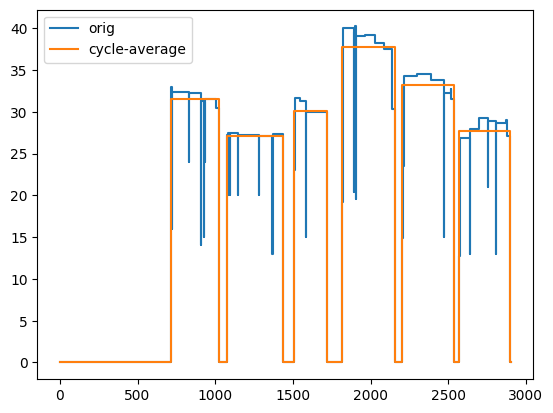

In [23]:
bh.plot_power_history(label='orig')
x = bh.classify_operations(min_shutdown_time=10.0)
new_time = bh.get_cycle_time(x)
bh2 = bh.regrid(new_time)
bh2.plot_power_history(label='cycle-average',add_to_existing=True)
burndata = []
for time,power in zip(bh2.interval_time,bh2.interval_power):
    burndata.append({"burn":time, "power":power})

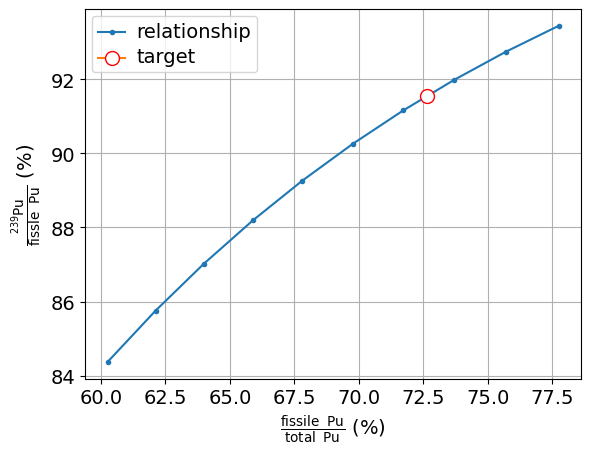

In [24]:
target_p=5.5
target_fp=72.64
x = contrib.sfcompo_guess_initial_mox(target_fp,target_p,plot=True)

In [25]:
tm=core.TemplateManager()
data={
    "_": {
        "env": {"work_dir": ""}, 
        "model": {"name": "mox_w14x14"}
    },
    "_arpinfo": {
        "interpvars": {
            "mod_dens": 0.75
        } 
    }, 
    "comp": {"system": x }, 
    "history": {
        "initialhm": 1, 
        "burndata": burndata
    }
}
contents = tm.expand('model/origami/system-mox.jt.inp',data)

In [26]:
# Remove the link for this use case.
def content_patch(contents):
    i=contents.find("=shell")
    e=contents.find('=origami')
    contents = contents.replace(contents[i:e],'')
    contents.replace('nlib=1','nlib=3')
    return contents
contents = content_patch(contents)
print(contents)

=origami

libs=[ mox_w14x14 ]

options{ ft71=all mtu=1 }

fuelcomp{
    stdcomp(c_uo2){ base=uo2 dens=10.4
        iso[
            92234=9.99999999998e-11
            92235=0.23099999999953796
            92236=9.99999999998e-11
            92238=99.76899999980047
        ]
    }
    stdcomp(c_puo2){ base=puo2 dens=10.4
        iso[
            94238=1.004872407301296
            94239=66.49989938874234
            94240=22.994586017532153
            94241=6.140090037926896
            94242=3.3605521484973133
        ]
    }
    stdcomp(c_am){ base=am  dens=10.4
        iso[
            95241=100.0
        ]
    }
    stdcomp(c_o2){ base=o  dens=10.4
    }
    mix(1){ comps[
        c_uo2 = 94.5000000000104
        c_puo2 = 5.499999999989605
        c_am = 4.8554667986940905e-22
        c_o2 = 6.445332012955142e-23
    ] }
}

modz = [ 0.75 ]
pz = [ 1.0 ]

hist[
  cycle{ power=0.0 burn=714.0 nlib=1 }
  cycle{ power=31.57569850552307 burn=307.79999999999995 nlib=1 }
  cycle{ power=0.0

In [43]:
td = core.TempDir()
path = td.write_file(contents,'origami.inp')
scalerte = scale_path + '/bin/scalerte'
sr = core.ScaleRunner(scalerte)

In [12]:
input,results = sr.run(path)
print(json.dumps(results,indent=4))

{
    "returncode": 0,
    "success": true,
    "errors": [],
    "command_line": "/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/scalerte ",
    "input_file": "/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami.inp",
    "output_file": "/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami.out",
    "message_file": "/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami.msg",
    "data_size": 109268059508,
    "scale_runtime_seconds": 21.559266090393066,
    "data_dir": "/Users/Shared/ornldev/code/scale/builds/master/INSTALL/data",
    "scalerte_path": "/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/scalerte",
    "input_file_hash": "b30ce0f63f549d558dbe3cd1c33a5f50",
    "version": "7.0.pre-b7",
    "runtime_seconds": 21.55981183052063,
    "rerun": true
}


In [29]:
import scale.olm.internal as internal
f71 = Path(results['input_file']).with_suffix('.f71')
print(f71,f71.exists())

/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami.f71 True


In [14]:
def get_ii_json(f71):
    obiwan = scale_path + '/bin/obiwan'
    ii_json = internal.run_command(f"{obiwan} view -format=ii.json -cases='[1]' {f71}",echo=False)
    return json.loads(ii_json)

In [37]:
def parse_csv(path, delim=';'):
    lines = []
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            lines.append(line.split(delim))

    return lines

measurements = parse_csv('data/Beznau-1_M308_K7_BM5_measurement.txt')
measurements = measurements[1:]
measurement_data_for_nuclide = {m[2]:m[8] for m in measurements}
print(measurement_data_for_nuclide)
# unit is DerivedUnit[mg/gUi,milligram/gram Uranium initial=1,Factors[mg.gUi^-1]]

{'U234': '5.082E-2', 'U235': '8.383E-1', 'U236': '3.040E-1', 'U238': '9.052E2', 'Np237': '1.985E-1', 'Pu238': '9.812E-1', 'Pu239': '1.049E1', 'Pu240': '1.088E1', 'Pu241': '5.071E0', 'Pu242': '3.993E0', 'Am241': '1.225E0', 'Am242m': '1.180E-2', 'Am243': '9.801E-1', 'Cm244': '8.497E-1', 'Cm245': '1.036E-1', 'Cm246': '1.690E-2', 'Ce144': '1.407E-2', 'Nd142': '3.233E-2', 'Nd143': '1.089E0', 'Nd144': '1.656E0', 'Nd145': '9.166E-1', 'Nd146': '1.067E0', 'Nd148': '6.160E-1', 'Nd150': '3.630E-1', 'Pm147': '7.566E-2', 'Sm147': '2.779E-1', 'Sm148': '3.290E-1', 'Sm149': '5.842E-3', 'Sm150': '5.343E-1', 'Sm151': '2.768E-2', 'Sm152': '1.997E-1', 'Sm154': '1.202E-1', 'Eu151': '8.565E-4', 'Eu153': '2.632E-1', 'Eu154': '6.001E-2', 'Eu155': '1.384E-2', 'Gd154': '3.131E-2', 'Gd155': '9.268E-3', 'Gd156': '2.949E-1', 'Gd158': '6.523E-2', 'Gd160': '4.889E-3', 'Sr90': '4.560E-1', 'Mo95': '1.063E0', 'Tc99': '1.214E0', 'Ru101': '1.452E0', 'Ru106': '2.859E-1', 'Rh103': '1.214E0', 'Ag109': '1.236E-1', 'Sb125': '

2023-09-11 19:27:47 [info     ] Running external               command_line=/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami.f71


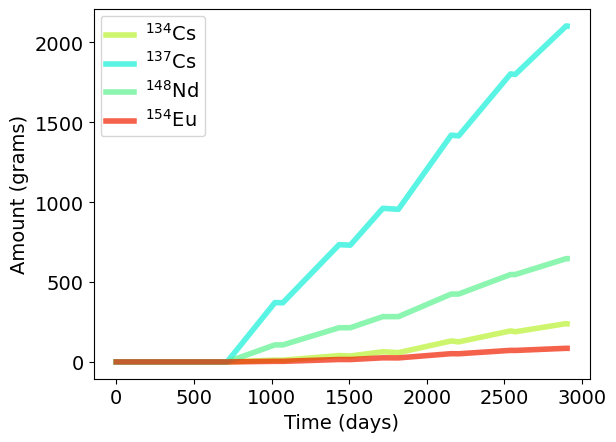

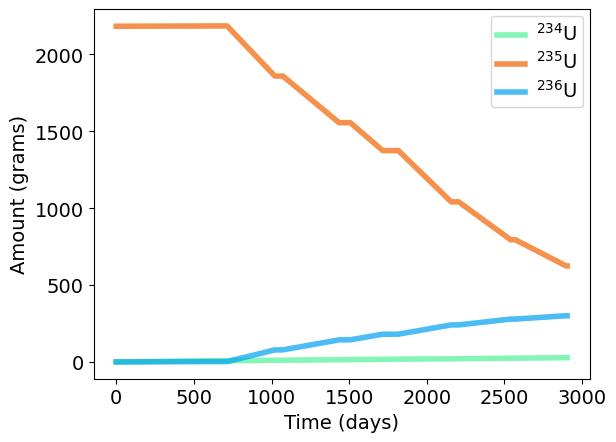

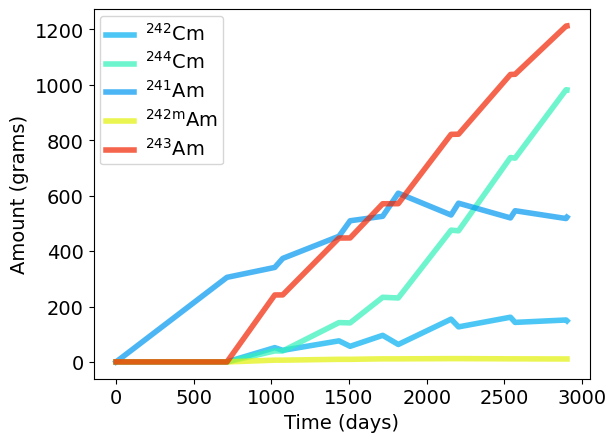

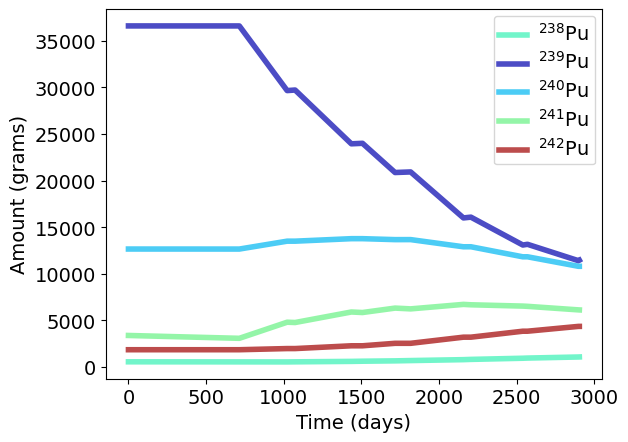

In [40]:
# Now we have all data loaded into memory.
# Let's make some plots.
base_ii = get_ii_json(f71)
base = core.InventoryInterface(base_ii)
ni_base = base.nuclide_inventory('case(1)')
nuclide_sets = []
nuclide_sets.append( ['cs134','cs137','nd148','eu154'] )
nuclide_sets.append( ['u234','u235','u236'] )
nuclide_sets.append( ['cm242','cm244','am241','am242m','am243'] )
nuclide_sets.append( ['pu238','pu239','pu240','pu241','pu242'] )
for nuclide_list in nuclide_sets:
    ni_base.plot_nuclide_amounts(nuclide_list,linewidth=4,alpha=0.7)
    contrib.change_plot_font_size(plt.gca(),14)
    plt.show()

In [51]:
import copy
time = [0]
time.extend( np.cumsum(bh2.interval_time) )
power_uncertainty = 0.10
power_perts = np.random.uniform(1.0-power_uncertainty,1.0+power_uncertainty,size=10000)
i=0
bh_list = []
nreal = 100
print('generating',nreal,'realizations')
for j in range(nreal):
    power = copy.deepcopy(bh2.interval_power)
    for k in range(len(power)):
        power[k]*=power_perts[i]
        i+=1
    burnup = [0]
    burnup.extend( np.cumsum(power*np.asarray(bh2.interval_time)) )
    bh_list.append( core.BurnupHistory(time,burnup) )

generating 100 realizations


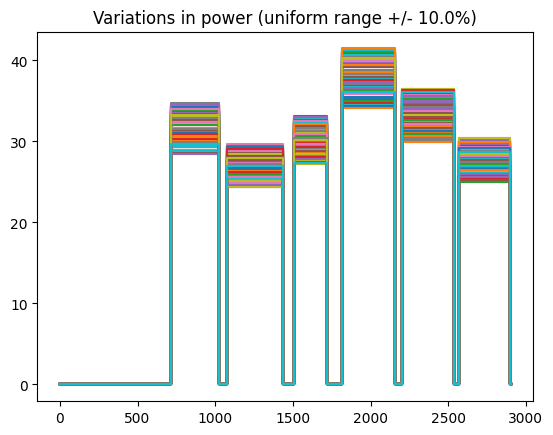

In [52]:
j=0
for bh in bh_list:
    bh.plot_power_history(label=str(j+1),add_to_existing=j!=0)
    j+=1
plt.title("Variations in power (uniform range +/- {:.1f}%)".format(100*power_uncertainty))
plt.gca().get_legend().remove()
plt.show()

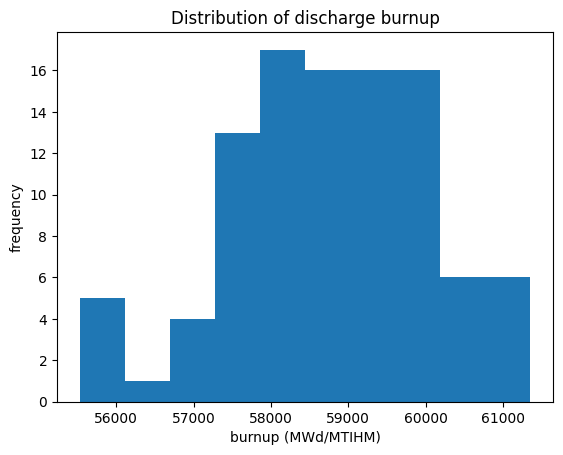

In [53]:
discharge_burnup=[]
for bh in bh_list:
    discharge_burnup.append( bh.burnup[-1] )
    j+=1
plt.hist(discharge_burnup)
plt.xlabel('burnup (MWd/MTIHM)')
plt.ylabel('frequency')
plt.title('Distribution of discharge burnup')
plt.show()

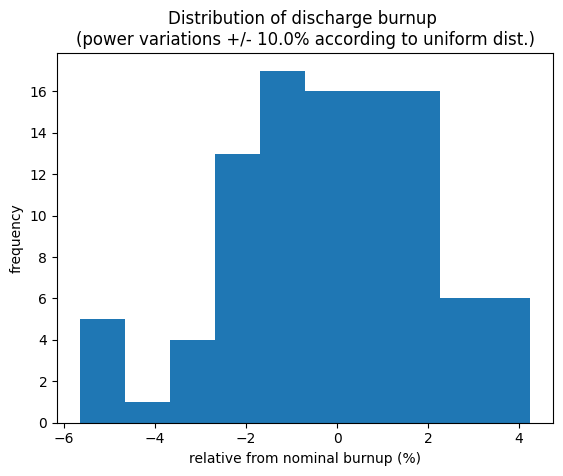

In [54]:
plt.hist(100*(discharge_burnup/bh2.burnup[-1] - 1))
plt.xlabel('relative from nominal burnup (%)')
plt.ylabel('frequency')
plt.title("Distribution of discharge burnup \n(power variations +/- {:.1f}% according to uniform dist.)".format(100*power_uncertainty))
plt.show()
# Note that sum of uniform distributions is 
# an Irwin-Hall distribution: https://en.wikipedia.org/wiki/Irwin%E2%80%93Hall_distribution

In [55]:
# Create all the inputs.
j=0
input_list=[]
for bh in bh_list:
    j+=1
    burndata = []
    for time,power in zip(bh.interval_time,bh.interval_power):
        burndata.append({"burn":time, "power":power})
    data['history']['burndata'] = burndata
    contents = tm.expand('model/origami/system-mox.jt.inp',data)
    path = td.write_file(contents,"origami{:03d}.inp".format(j))
    input_list.append(path)

In [57]:
# Create a thread executor.
num_workers=6
tpe = core.ThreadPoolExecutor(max_workers=num_workers)

In [58]:
results = tpe.execute(sr.run,input_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:02<00:00,  4.82s/it]


In [59]:
for r in results:
    print(r)

/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami002.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami006.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami003.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami001.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami004.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami005.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami008.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami010.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami011.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami007.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami012.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami009.inp
/var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami015.inp
/var/folders

In [63]:
f71_list = []
for r in results:
    f71_list.append( Path(results[r]['input_file']).with_suffix('.f71') )

In [64]:
def ii_json_runner(input_f71):
    return input_f71, get_ii_json(input_f71)
results_ii = tpe.execute(ii_json_runner,f71_list)

  0%|                                                                                                                                              | 0/100 [00:00<?, ?it/s]2023-09-11 19:39:09 [info     ] Running external               command_line=/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami002.f71
2023-09-11 19:39:09 [info     ] Running external               command_line=/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami006.f71
2023-09-11 19:39:09 [info     ] Running external               command_line=/Users/Shared/ornldev/code/scale/builds/master/INSTALL/bin/obiwan view -format=ii.json -cases='[1]' /var/folders/gd/ns6g1ncd7kgbxglpynczvlznxpq4sw/T/tmp0i7cyge2/origami003.f71
2023-09-11 19:39:09 [info     ] Running external               command_li

In [65]:
xx=dict()
for k,v in results_ii.items():
    xx[k.stem] = core.InventoryInterface(v).nuclide_inventory('case(1)') 

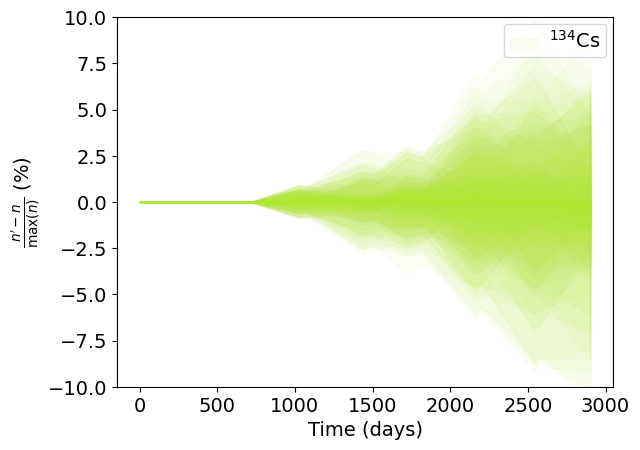

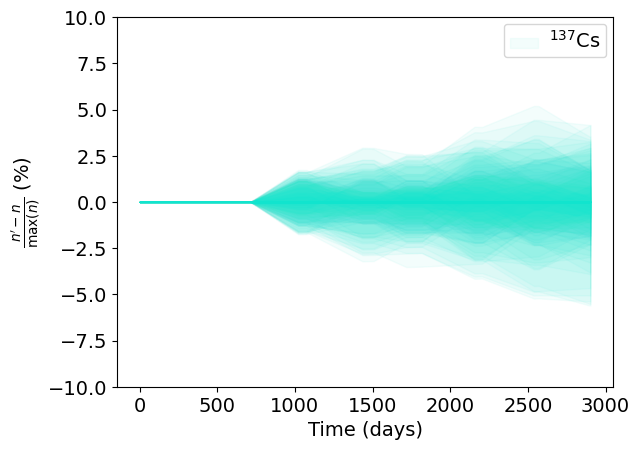

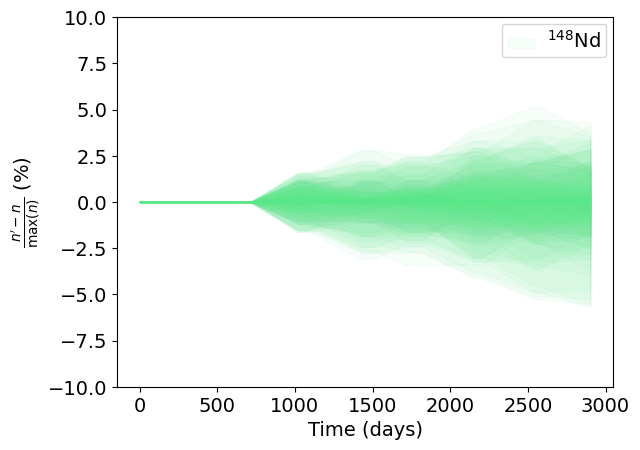

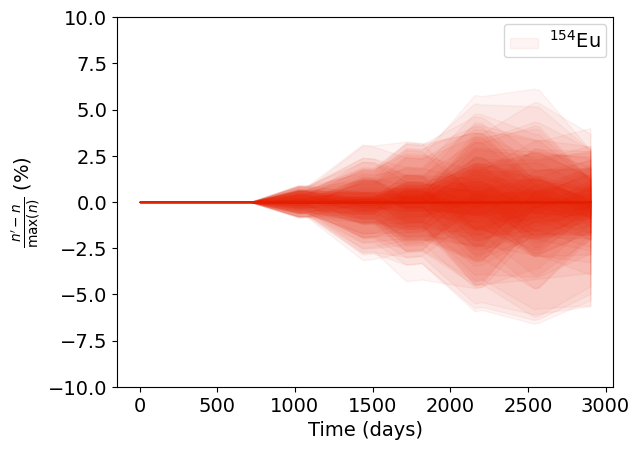

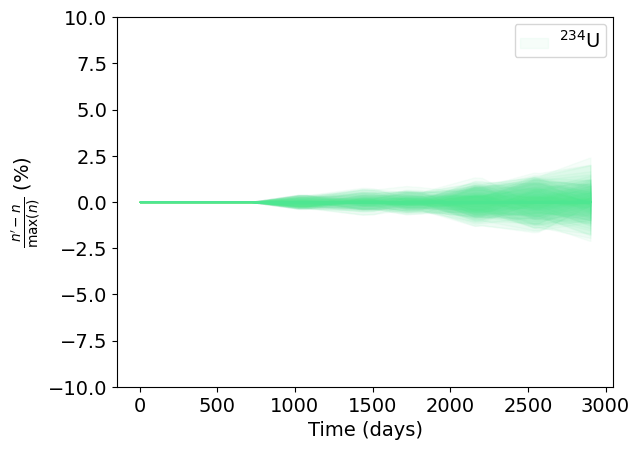

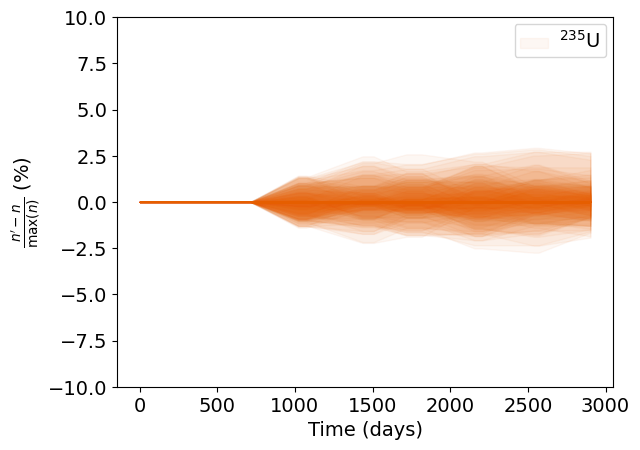

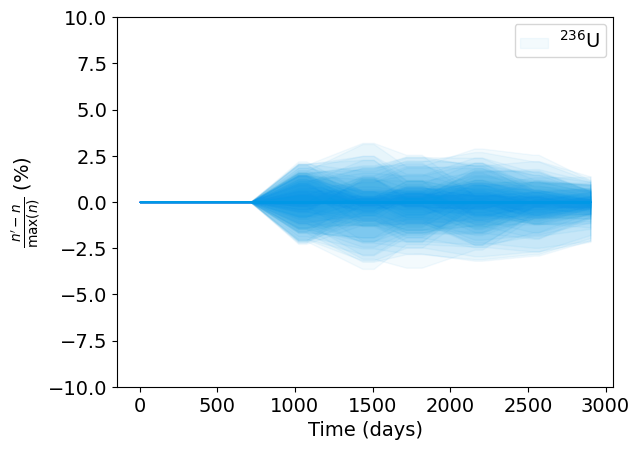

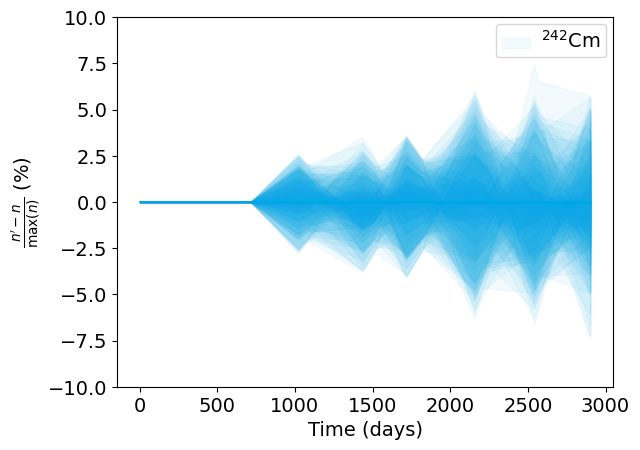

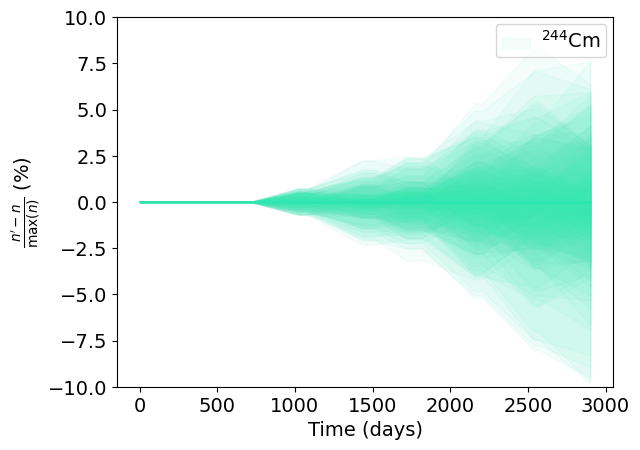

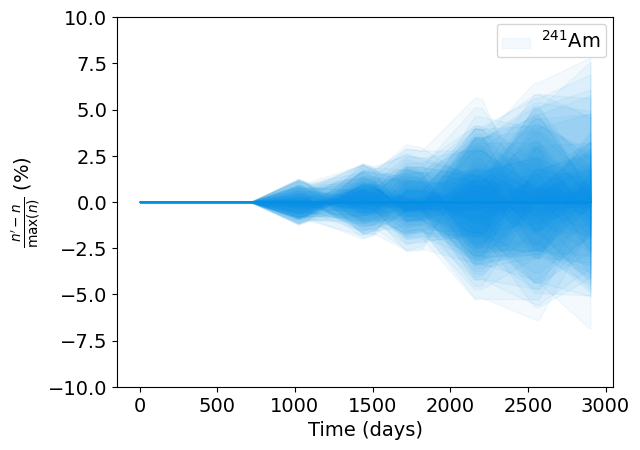

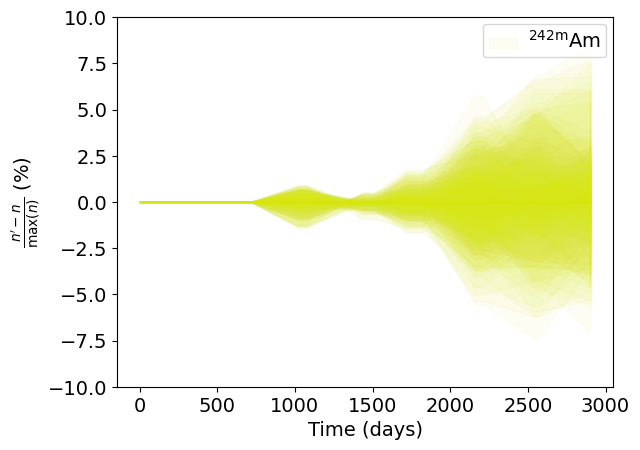

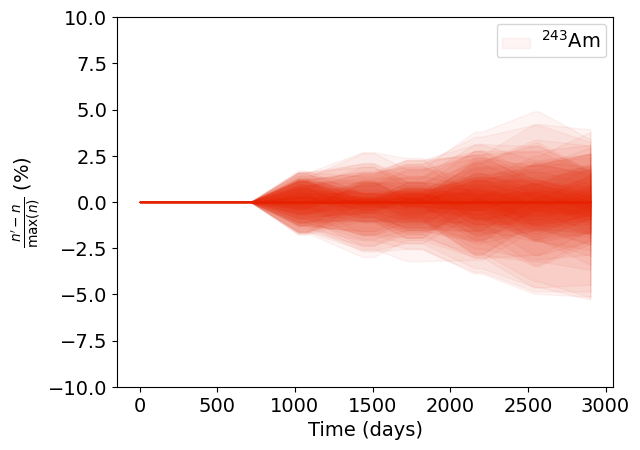

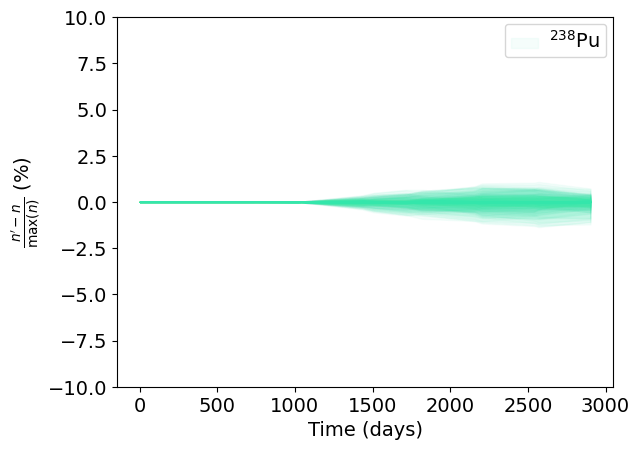

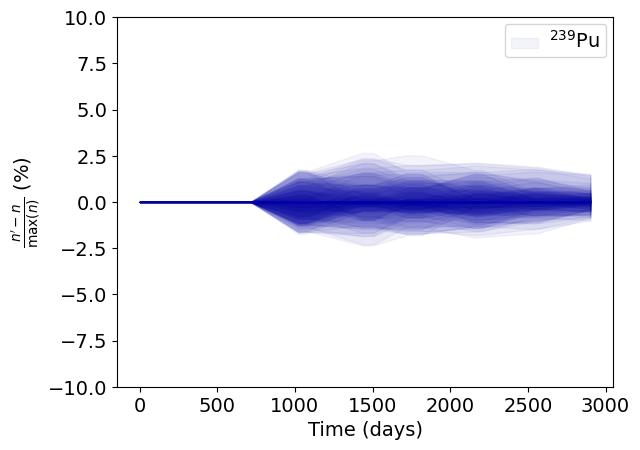

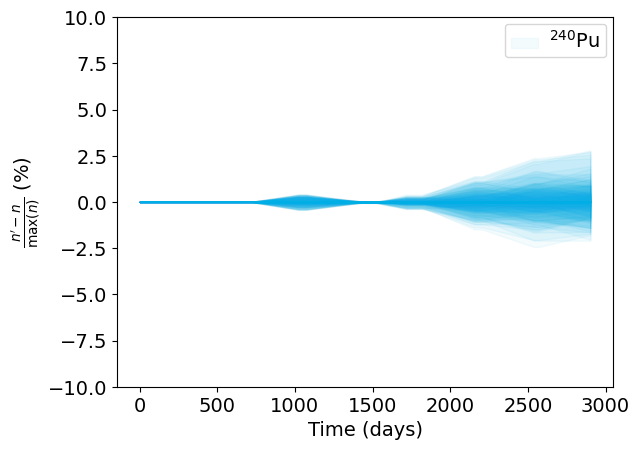

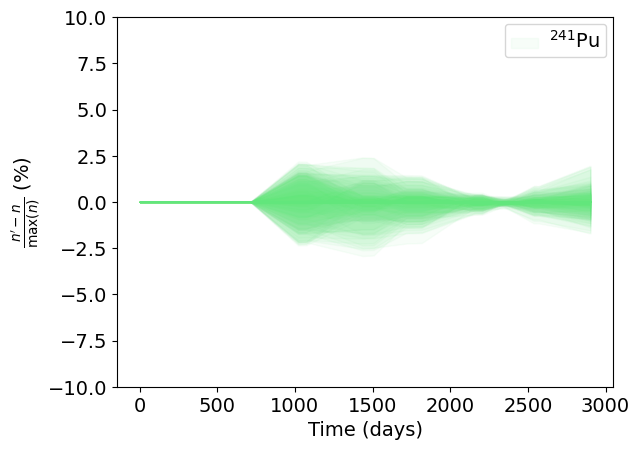

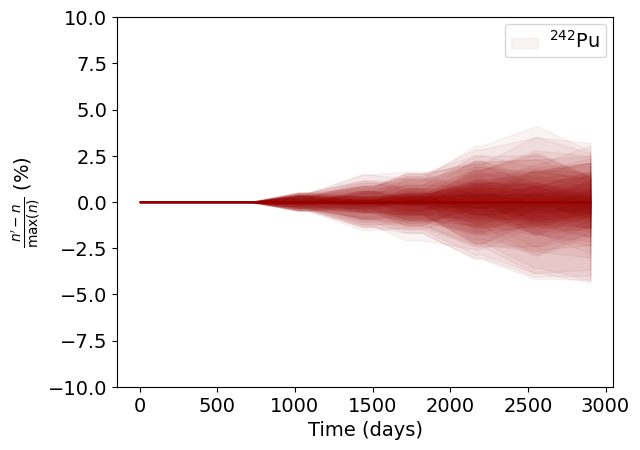

In [69]:
for nuclide_list in nuclide_sets:
    for nuclide in nuclide_list:
        for k,v in xx.items():
            color0=core.NuclideInventory._nuclide_color(ni_base.composition_manager.izzzaaa(nuclide))
            plt.fill_between(ni_base.time/86400.,
                     100*v.wrel_diff(nuclide,ni_base.get_amount(nuclide)), alpha=1/(1+0.2*len(xx)),
                     color=np.asarray(color0)*0.95 )
        plt.ylim([-100*power_uncertainty,100*power_uncertainty])
        plt.xlabel("Time (days)")
        plt.ylabel(r"$\frac{n'-n}{\mathrm{max}(n)}$ (%)")
        plt.legend([ni_base._nice_label(nuclide)])
        contrib.change_plot_font_size(plt.gca(),14)
        plt.show()